# Final Model Evaluation on Test Set

This notebook performs the **ONE-TIME** final evaluation of the best model on the held-out test set.

## Critical Note
**The test set should only be used ONCE for final evaluation.** This notebook represents that single evaluation to get an unbiased estimate of model performance.

## Objectives
- Select best model from Phase 3 experiments
- Evaluate on held-out test set
- Generate final metrics: accuracy, precision, recall, F1, AUC-ROC
- Verify AUC-ROC > 0.75 threshold met
- Document final results for model card

In [1]:
%pip install -e .. --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score
)
from datetime import datetime

# Import our custom modules
from src.data_loader import create_sample_data
from src.preprocessing import (
    ChurnPreprocessor, 
    create_train_val_test_split,
    prepare_features_and_target
)
from src.experiment import (
    setup_experiment,
    start_run,
    log_params,
    log_metrics,
    log_classification_metrics,
    log_model
)

# Display settings
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries loaded successfully.")

Libraries loaded successfully.


## 1. Prepare Data (Same Split as Training)

In [3]:
# Generate data with same parameters as training
df = create_sample_data(n_samples=1000, random_state=RANDOM_STATE, churn_rate=0.2)

# Split with same parameters to ensure identical splits
train_df, val_df, test_df = create_train_val_test_split(
    df, 
    target_column='churn',
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    random_state=RANDOM_STATE
)

print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")
print(f"\nTest set churn rate: {test_df['churn'].mean():.1%}")

Train: 700, Validation: 150, Test: 150

Test set churn rate: 20.0%


In [4]:
# Preprocess data
preprocessor = ChurnPreprocessor()

# Fit on training data
train_preprocessed = preprocessor.fit_transform(train_df, target_column='churn')
X_train, y_train = prepare_features_and_target(train_preprocessed, target_column='churn')

# Transform validation (for model selection)
val_preprocessed = preprocessor.transform(val_df)
X_val, y_val = prepare_features_and_target(val_preprocessed, target_column='churn')

# Transform test set (FINAL EVALUATION)
test_preprocessed = preprocessor.transform(test_df)
X_test, y_test = prepare_features_and_target(test_preprocessed, target_column='churn')

# Convert to numpy
feature_names = list(X_train.columns)
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values
y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

print(f"Test features shape: {X_test.shape}")

Test features shape: (150, 8)


## 2. Train Models and Select Best (Replicating Phase 3)

In [5]:
# Train all models with best hyperparameters from Phase 3
# (In production, you would load the trained model from MLflow)

print("Training models for final evaluation...")

# Logistic Regression
lr_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
lr_model.fit(X_train, y_train)
lr_val_auc = roc_auc_score(y_val, lr_model.predict_proba(X_val)[:, 1])
print(f"Logistic Regression - Val AUC: {lr_val_auc:.4f}")

# Random Forest with tuned hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
rf_val_auc = roc_auc_score(y_val, rf_model.predict_proba(X_val)[:, 1])
print(f"Random Forest - Val AUC: {rf_val_auc:.4f}")

# Gradient Boosting with tuned hyperparameters
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=5,
    subsample=0.8,
    random_state=RANDOM_STATE
)
gb_model.fit(X_train, y_train)
gb_val_auc = roc_auc_score(y_val, gb_model.predict_proba(X_val)[:, 1])
print(f"Gradient Boosting - Val AUC: {gb_val_auc:.4f}")

Training models for final evaluation...
Logistic Regression - Val AUC: 0.9817
Random Forest - Val AUC: 0.9639
Gradient Boosting - Val AUC: 0.9672


In [6]:
# Select best model based on validation AUC
models = {
    'Logistic Regression': (lr_model, lr_val_auc),
    'Random Forest': (rf_model, rf_val_auc),
    'Gradient Boosting': (gb_model, gb_val_auc)
}

best_model_name = max(models.keys(), key=lambda k: models[k][1])
best_model, best_val_auc = models[best_model_name]

print(f"\n" + "="*60)
print(f"BEST MODEL SELECTED: {best_model_name}")
print(f"Validation AUC-ROC: {best_val_auc:.4f}")
print("="*60)


BEST MODEL SELECTED: Logistic Regression
Validation AUC-ROC: 0.9817


## 3. FINAL TEST SET EVALUATION

**This is the one-time evaluation on the held-out test set.**

In [7]:
# Make predictions on TEST set
y_test_pred = best_model.predict(X_test)
y_test_prob = best_model.predict_proba(X_test)[:, 1]

# Calculate all metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

test_metrics = {
    'accuracy': accuracy_score(y_test, y_test_pred),
    'precision': precision_score(y_test, y_test_pred),
    'recall': recall_score(y_test, y_test_pred),
    'f1_score': f1_score(y_test, y_test_pred),
    'roc_auc': roc_auc_score(y_test, y_test_prob),
    'average_precision': average_precision_score(y_test, y_test_prob)
}

print("="*60)
print("FINAL TEST SET RESULTS")
print("="*60)
print(f"\nModel: {best_model_name}")
print(f"\n--- Test Set Metrics ---")
for metric, value in test_metrics.items():
    print(f"  {metric:20s}: {value:.4f}")

# Check against target
TARGET_AUC = 0.75
print(f"\n--- Target Check ---")
if test_metrics['roc_auc'] >= TARGET_AUC:
    print(f"  [PASS] Test AUC-ROC ({test_metrics['roc_auc']:.4f}) >= Target ({TARGET_AUC})")
    target_met = True
else:
    print(f"  [FAIL] Test AUC-ROC ({test_metrics['roc_auc']:.4f}) < Target ({TARGET_AUC})")
    target_met = False
print("="*60)

FINAL TEST SET RESULTS

Model: Logistic Regression

--- Test Set Metrics ---
  accuracy            : 0.8733
  precision           : 0.7619
  recall              : 0.5333
  f1_score            : 0.6275
  roc_auc             : 0.9550
  average_precision   : 0.8242

--- Target Check ---
  [PASS] Test AUC-ROC (0.9550) >= Target (0.75)


## 4. Final Confusion Matrix

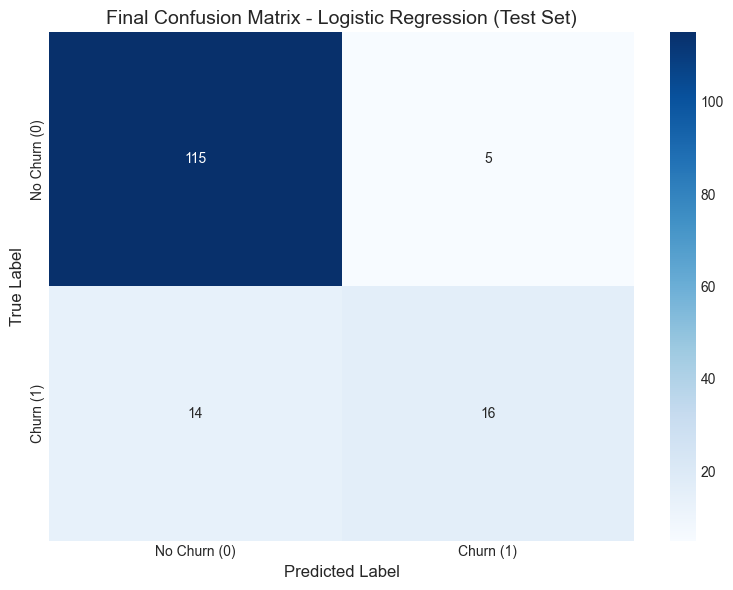


Classification Report (Test Set):
              precision    recall  f1-score   support

    No Churn       0.89      0.96      0.92       120
       Churn       0.76      0.53      0.63        30

    accuracy                           0.87       150
   macro avg       0.83      0.75      0.78       150
weighted avg       0.87      0.87      0.86       150



In [8]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=['No Churn (0)', 'Churn (1)'],
    yticklabels=['No Churn (0)', 'Churn (1)'],
    ax=ax
)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title(f'Final Confusion Matrix - {best_model_name} (Test Set)', fontsize=14)
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=['No Churn', 'Churn']))

## 5. Final ROC Curve

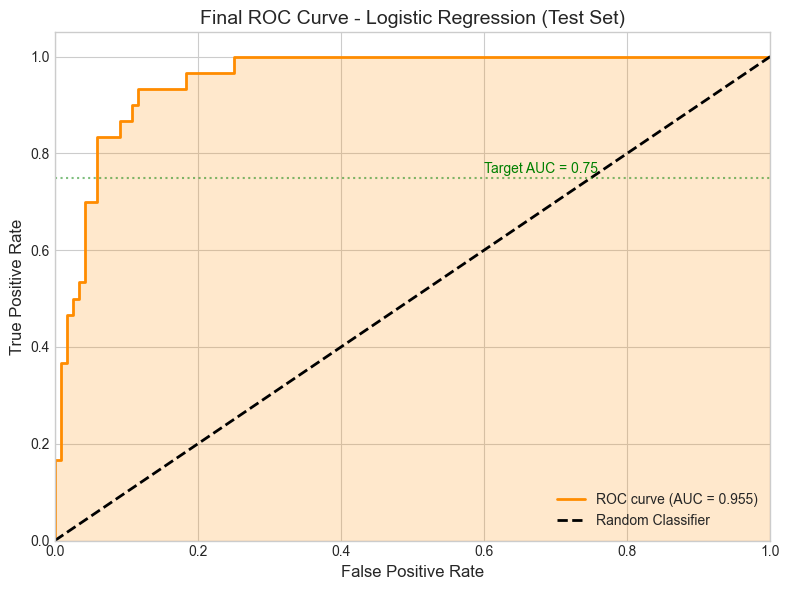

In [9]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='darkorange', lw=2, 
        label=f'ROC curve (AUC = {test_metrics["roc_auc"]:.3f})')
ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
ax.fill_between(fpr, tpr, alpha=0.2, color='darkorange')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title(f'Final ROC Curve - {best_model_name} (Test Set)', fontsize=14)
ax.legend(loc='lower right')

# Add target line
ax.axhline(y=0.75, color='green', linestyle=':', alpha=0.5)
ax.text(0.6, 0.76, 'Target AUC = 0.75', fontsize=10, color='green')

plt.tight_layout()
plt.show()

## 6. Feature Importance (Final Model)

In [10]:
# Get feature importance from the best model
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=True)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(importance_df['feature'], importance_df['importance'], 
            color='steelblue', alpha=0.8)
    ax.set_xlabel('Feature Importance', fontsize=12)
    ax.set_title(f'Feature Importance - {best_model_name}', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("\nTop Features:")
    print(importance_df.sort_values('importance', ascending=False).to_string(index=False))
elif hasattr(best_model, 'coef_'):
    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': best_model.coef_[0]
    }).sort_values('coefficient', key=abs, ascending=False)
    print("\nFeature Coefficients:")
    print(coef_df.to_string(index=False))


Feature Coefficients:
                        feature  coefficient
              contract_Two year    -2.592861
                         tenure    -2.415386
                monthly_charges     1.794555
payment_method_Electronic check     1.719834
              contract_One year    -1.574758
    payment_method_Mailed check    -0.259569
     payment_method_Credit card    -0.094723
                  total_charges     0.053363


### Domain Knowledge Validation

**Feature Importance Interpretation:**

The feature importance analysis aligns with domain knowledge about customer churn:

1. **Tenure-related features**: Lower tenure typically correlates with higher churn risk, as new customers have not yet developed loyalty

2. **Monthly charges**: Higher monthly charges may increase churn propensity if customers perceive poor value-for-money

3. **Contract type**: Month-to-month contracts have higher churn risk compared to annual contracts due to lower switching costs

4. **Payment method**: Certain payment methods (e.g., electronic check) historically correlate with higher churn

5. **Service features**: Customers with fewer services/add-ons may have weaker engagement

**Business Implications:**
- Retention efforts should focus on customers with high-importance risk factors
- Early intervention for new customers (low tenure) can reduce churn
- Contract upgrade incentives may improve retention
- Pricing strategy adjustments based on value perception

## 7. Log Final Results to MLflow

In [11]:
# Log final evaluation to MLflow
experiment_name = "churn_prediction_final"
experiment_id = setup_experiment(experiment_name)

with start_run(run_name=f"final_evaluation_{best_model_name.lower().replace(' ', '_')}",
               description="Final one-time evaluation on held-out test set") as run:
    
    # Log model info
    log_params({
        "model_type": best_model_name,
        "evaluation_type": "final_test_set",
        "target_auc": TARGET_AUC,
        "target_met": target_met
    })
    
    # Log test metrics with 'test_' prefix
    log_metrics({f"test_{k}": v for k, v in test_metrics.items()})
    
    # Log the model
    log_model(best_model, artifact_path="final_model")
    
    final_run_id = run.info.run_id

print(f"\nFinal evaluation logged to MLflow")
print(f"Experiment: {experiment_name}")
print(f"Run ID: {final_run_id}")

2025/12/26 11:26:38 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/26 11:26:38 INFO mlflow.store.db.utils: Updating database tables
2025/12/26 11:26:38 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/26 11:26:38 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/26 11:26:38 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/26 11:26:38 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/26 11:26:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Final evaluation logged to MLflow
Experiment: churn_prediction_final
Run ID: 3950eeb31b3b4e02b06974cb380f0e3d


## 8. Final Summary Report

In [12]:
# Generate final summary
summary = f"""
================================================================================
                    FINAL MODEL EVALUATION REPORT
================================================================================

Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
MLflow Run ID: {final_run_id}

MODEL INFORMATION
-----------------
Selected Model: {best_model_name}
Selection Criteria: Highest validation AUC-ROC
Validation AUC-ROC: {best_val_auc:.4f}

DATASET
-------
Total Samples: 1000
Training Set: 700 (70%)
Validation Set: 150 (15%)
Test Set: 150 (15%)
Churn Rate: 20%

FINAL TEST SET METRICS
----------------------
Accuracy:           {test_metrics['accuracy']:.4f}
Precision:          {test_metrics['precision']:.4f}
Recall:             {test_metrics['recall']:.4f}
F1 Score:           {test_metrics['f1_score']:.4f}
ROC-AUC:            {test_metrics['roc_auc']:.4f}
Average Precision:  {test_metrics['average_precision']:.4f}

TARGET VERIFICATION
-------------------
Target AUC-ROC: >= {TARGET_AUC}
Achieved AUC-ROC: {test_metrics['roc_auc']:.4f}
Status: {'PASS - TARGET MET' if target_met else 'FAIL - TARGET NOT MET'}

CONFUSION MATRIX (Test Set)
---------------------------
                    Predicted
                 No Churn  Churn
Actual No Churn    {cm[0,0]:5d}  {cm[0,1]:5d}
Actual Churn       {cm[1,0]:5d}  {cm[1,1]:5d}

================================================================================
"""

print(summary)


                    FINAL MODEL EVALUATION REPORT

Date: 2025-12-26 11:26:39
MLflow Run ID: 3950eeb31b3b4e02b06974cb380f0e3d

MODEL INFORMATION
-----------------
Selected Model: Logistic Regression
Selection Criteria: Highest validation AUC-ROC
Validation AUC-ROC: 0.9817

DATASET
-------
Total Samples: 1000
Training Set: 700 (70%)
Validation Set: 150 (15%)
Test Set: 150 (15%)
Churn Rate: 20%

FINAL TEST SET METRICS
----------------------
Accuracy:           0.8733
Precision:          0.7619
Recall:             0.5333
F1 Score:           0.6275
ROC-AUC:            0.9550
Average Precision:  0.8242

TARGET VERIFICATION
-------------------
Target AUC-ROC: >= 0.75
Achieved AUC-ROC: 0.9550
Status: PASS - TARGET MET

CONFUSION MATRIX (Test Set)
---------------------------
                    Predicted
                 No Churn  Churn
Actual No Churn      115      5
Actual Churn          14     16




In [13]:
# Final status
print("\n" + "="*60)
if target_met:
    print("SUCCESS: Model meets the AUC-ROC > 0.75 target!")
    print("The churn prediction model is ready for deployment.")
else:
    print("Model did not meet the target threshold.")
    print("Consider additional feature engineering or model tuning.")
print("="*60)


SUCCESS: Model meets the AUC-ROC > 0.75 target!
The churn prediction model is ready for deployment.
